## Exploring Battle Logs

In [373]:
from bs4 import BeautifulSoup


## Constants

In [374]:

INPUT_DIR="../battle_data"
OUTPUT_DIR="../stats_data"


UNKNOWN_POKEMON = '__UNKNOWN_POKEMON__'
NO_POKEMON = '__NO_POKEMON__'
UNKNOWN_RATING = None


## Generating Battle CSV Data

In [375]:
class Player:
    def __init__(self, id, logs):
        self.id = id
        
        for log in logs:
            if log[0] == "player" and log[1] == id and len(log) > 2:
                self.player_name = log[2]
                self.rating = UNKNOWN_RATING if len(log[4]) == 0 else int(log[4])
                break



In [376]:

class Pokemon:
    def __init__(self, player, id, species, logs):
        self.id = id
        self.player = player
        self.species = species
        self._logs = logs



In [377]:
class PokemonTeam:
    def __init__(self, player, logs):
        self.player = player
        self._logs = logs
        self._pokemon_map = {}
        self._pokemon = []
        self._load_pokemon()


    def __len__(self):
        for log in self._logs:
            if log[0] == 'teamsize' and log[1] == self.player.id:
                return int(log[2])

        return 0


    def __getitem__(self, i):
        return self._pokemon[i]


    def __iter__(self):
        for poke in self._pokemon:
            yield poke


    @property
    def has_unknown_pokemon(self):
        for p in self._pokemon:
            if p.species == UNKNOWN_POKEMON:
                return True

        return False


    @property
    def known_count(self):
        count = 0
        for p in self._pokemon:
            if p.species != UNKNOWN_POKEMON:
                count += 1

        return count


    def _load_pokemon(self):
        prefix = self.player.id + "a: "
        count = len(self)
        found_count = 0

        for log in self._logs:
            player_prefix = self.player.id + "a: "
            if log[0] == 'switch' and log[1].startswith(player_prefix):
                p_id = log[1]

                if p_id in self._pokemon_map:
                    continue

                species = p_id[len(player_prefix):]

                pokemon = Pokemon(player=self.player, id=p_id, species=species, logs=self._logs)

                self._pokemon_map[p_id] = len(self._pokemon)
                self._pokemon.append(pokemon)
                found_count += 1

        while found_count < count:
            p_id = prefix + UNKNOWN_POKEMON + " " + str(count - found_count)
            pokemon = Pokemon(player=self.player, id=p_id, species=UNKNOWN_POKEMON, logs=self._logs)
            self._pokemon_map[p_id] = len(self._pokemon)
            self._pokemon.append(pokemon)
            found_count += 1




In [378]:
class BattleLogs:
    def __init__(self, logs):
        self._logs = logs
        self.p1 = Player(id="p1", logs=logs)
        self.p2 = Player(id="p2", logs=logs)

 
    @property
    def turn_count(self):
        count = 0
        for log in self._logs:
            if log[0] == "turn":
                count = max(count, int(log[1]))

        return count


    @property
    def tier(self):
        for log in self._logs:
            if log[0] == "tier":
                return log[1]

    @property
    def is_rated(self):
        for log in self._logs:
            if log[0] == 'rated':
                return True

        return False

    
    @property
    def rules(self):
        return [x[1] for x in self._logs if x[0] == 'rule']


    @property
    def p1_team(self):
        return PokemonTeam(player=self.p1, logs=self._logs)


    @property
    def p2_team(self):
        return PokemonTeam(player=self.p2, logs=self._logs)


    @property
    def winner(self):
        for log in self._logs:
            if log[0] == "win":
                player_name = log[1]
                break

        if self.p1.player_name == player_name:
            return self.p1
        elif self.p2.player_name == player_name:
            return self.p2
        else:
            return None



In [379]:
import pandas as pd

# Number of log files we have in our data.
LOGS_COUNT = 225


In [380]:
with open('../battle_data/0001.html') as file:
    soup = BeautifulSoup(file, "html.parser")
    el = soup.find_all("script", class_="battle-log-data")[0]
    raw_logs = [x.split('|')[1:] for x in el.text.split('\n') if len(x) > 0]

logs = BattleLogs(logs=raw_logs)

for pokemon in logs.p2_team:
    print(pokemon.species)

print(logs.winner)


Duraludon
Archeops
Gothitelle
Regidrago
Darmanitan
Lunala


In [381]:
pokedex = pd.read_csv('../stats_data/dex.csv')


In [382]:
def generate_frame(logs_count):
    idx = [
        'p1_name',
        'p2_name',
        'p_winner',
        'is_rated_battle',
        'p1_rating',
        'p2_rating',
        'team1_count',
        'team2_count',
        'turn_count',
        'p1_poke1',
        'p1_poke2',
        'p1_poke3',
        'p1_poke4',
        'p1_poke5',
        'p1_poke6',
        'p2_poke1',
        'p2_poke2',
        'p2_poke3',
        'p2_poke4',
        'p2_poke5',
        'p2_poke6',
        'team1_unknown_count',
        'team2_unknown_count']

    df = pd.DataFrame()
    list = []

    for i in range(logs_count):
        filename = INPUT_DIR + "/" + str(i + 1).zfill(4) + ".html"

        with open(filename) as file:
                soup = BeautifulSoup(file, "html.parser")
                el = soup.find_all("script", class_="battle-log-data")[0]
                raw_logs = [x.split('|')[1:] for x in el.text.split('\n') if len(x) > 0]

        logs = BattleLogs(raw_logs)

        p1_team_len = len(logs.p1_team)
        p2_team_len = len(logs.p2_team)

        list.append(pd.Series([
            logs.p1.player_name,
            logs.p2.player_name,
            logs.winner.id,
            logs.is_rated,
            logs.p1.rating,
            logs.p2.rating,
            p1_team_len,
            p2_team_len,
            logs.turn_count,
            NO_POKEMON if len(logs.p1_team) <= 0 else logs.p1_team[0].species,
            NO_POKEMON if len(logs.p1_team) <= 1 else logs.p1_team[1].species,
            NO_POKEMON if len(logs.p1_team) <= 2 else logs.p1_team[2].species,
            NO_POKEMON if len(logs.p1_team) <= 3 else logs.p1_team[3].species,
            NO_POKEMON if len(logs.p1_team) <= 4 else logs.p1_team[4].species,
            NO_POKEMON if len(logs.p1_team) <= 5 else logs.p1_team[5].species,
            NO_POKEMON if len(logs.p1_team) <= 0 else logs.p1_team[0].species,
            NO_POKEMON if len(logs.p1_team) <= 1 else logs.p1_team[1].species,
            NO_POKEMON if len(logs.p1_team) <= 2 else logs.p1_team[2].species,
            NO_POKEMON if len(logs.p1_team) <= 3 else logs.p1_team[3].species,
            NO_POKEMON if len(logs.p1_team) <= 4 else logs.p1_team[4].species,
            NO_POKEMON if len(logs.p1_team) <= 5 else logs.p1_team[5].species,
            p1_team_len - logs.p1_team.known_count,
            p2_team_len - logs.p2_team.known_count,
        ]))

    df = pd.concat(list, axis=1).T
    df.columns = idx
    return df



In [383]:
df= generate_frame(LOGS_COUNT)
df

,p1_name,p2_name,p_winner,is_rated_battle,p1_rating,p2_rating,team1_count,team2_count,turn_count,p1_poke1,...,p1_poke5,p1_poke6,p2_poke1,p2_poke2,p2_poke3,p2_poke4,p2_poke5,p2_poke6,team1_unknown_count,team2_unknown_count
0,Rhodes28,sbq1e,p1,True,1391,1440,6,6,12,Dragapult,...,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,Dragapult,Darmanitan,Lycanroc,Lapras,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,2,0
1,Xebrilag27,Rage69,p2,True,1754,1784,6,6,26,Arctovish,...,Electivire,Sirfetch’d,Arctovish,Salazzle,Jellicent,Blacephalon,Electivire,Sirfetch’d,0,1
2,Raccoonis,WhoIsJoeLigma?,p1,True,1085,1058,6,6,23,Haxorus,...,Luxray,__UNKNOWN_POKEMON__,Haxorus,Urshifu,Dubwool,Duraludon,Luxray,__UNKNOWN_POKEMON__,1,0
3,bembi,SecondaryStomach,p1,True,1269,1315,6,6,14,Ludicolo,...,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,Ludicolo,Thundurus,Magearna,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,3,0
4,MrCrunchBar,Primainprime,p2,False,None,None,6,6,14,Centiskorch,...,Solgaleo,Talonflame,Centiskorch,Scyther,Togedemaru,Venusaur,Solgaleo,Talonflame,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,SecretFBIAgent,bukka,p1,True,1077,1019,6,6,20,Cryogonal,...,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,Cryogonal,Slowking,Dugtrio,Necrozma,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,2,1
221,BurningAud,Bruh Wobuffet,p2,True,1683,1692,6,6,24,Cursola,...,Giratina,Ribombee,Cursola,Bisharp,Kingdra,Thundurus,Giratina,Ribombee,0,0
222,gustavohiei,Miravetizin,p1,False,None,None,6,6,15,Charizard,...,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,Charizard,Entei,Cryogonal,Pelipper,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,2,0
223,Chozen247,143 bpm,p1,True,1381,1428,6,6,14,Jynx,...,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,Jynx,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,__UNKNOWN_POKEMON__,5,0


### Filtering Outliers

Are there any teams that do not have 6 Pokémon total?

In [384]:
not_6_team_battles = df[(df["team1_count"] != 6) | (df["team2_count"] != 6)]
not_6_team_battles


,p1_name,p2_name,p_winner,is_rated_battle,p1_rating,p2_rating,team1_count,team2_count,turn_count,p1_poke1,...,p1_poke5,p1_poke6,p2_poke1,p2_poke2,p2_poke3,p2_poke4,p2_poke5,p2_poke6,team1_unknown_count,team2_unknown_count
17,Giga㋛Chandelure-,Sinpleto,p1,True,None,None,3,3,14,Crustle,...,__NO_POKEMON__,__NO_POKEMON__,Crustle,Genesect,Vespiquen,__NO_POKEMON__,__NO_POKEMON__,__NO_POKEMON__,0,0
44,RobinOfYlisse,Mbouchon,p2,True,None,None,24,24,14,Goodra,...,Dragapult,Latias,Goodra,Duraludon,Flygon,Rayquaza,Dragapult,Latias,18,20


What are the statistics around turn counts?

In [385]:
turn_counts = df["turn_count"]

(
    ("0.01 Quantile:", turn_counts.quantile(0.01)),
    ("0.10 Quantile:", turn_counts.quantile(0.10)),
    ("0.50 Quantile:", turn_counts.quantile(0.50)),
    ("0.90 Quantile:", turn_counts.quantile(0.90)),
    ("0.99 Quantile:", turn_counts.quantile(0.99)),
)



(('0.01 Quantile:', 1.2400000000000002),
 ('0.10 Quantile:', 8.0),
 ('0.50 Quantile:', 21.0),
 ('0.90 Quantile:', 31.599999999999994),
 ('0.99 Quantile:', 56.75999999999999))

Let's filter out any battles that are conducted with more of less than 6 Pokémon teams or last less than 2 turns.

In [386]:
valid_battles = df[(df["team1_count"] == 6) & (df["team2_count"] == 6) & (df["turn_count"] >= 2)]
valid_battles.shape[0]

220

## Exploring the Data

What portion of Pokémon are unknown for the different teams?

In [387]:
unknown_counts = pd.concat([valid_battles["team1_unknown_count"], valid_battles["team2_unknown_count"]])
unknown_counts

(
    ("0.25 Quantile:", unknown_counts.quantile(0.25)),
    ("0.50 Quantile:", unknown_counts.quantile(0.50)),
    ("0.75 Quantile:", unknown_counts.quantile(0.75)),
    ("0.90 Quantile:", unknown_counts.quantile(0.90)),
    ("0.99 Quantile:", unknown_counts.quantile(0.99)),
    ("Mean:",          unknown_counts.mean()),
)



(('0.25 Quantile:', 0.0),
 ('0.50 Quantile:', 0.0),
 ('0.75 Quantile:', 2.0),
 ('0.90 Quantile:', 3.0),
 ('0.99 Quantile:', 5.0),
 ('Mean:', 1.0340909090909092))

How many rated battles are there?

In [388]:

rated_count = valid_battles[valid_battles["is_rated_battle"]].shape[0]

(rated_count, rated_count / valid_battles.shape[0])


(195, 0.8863636363636364)

Which Pokemon are frequently used?

In [389]:
from collections import Counter


In [390]:
def gen_pokemon_statistics(df, players):
    starter_pokemon_counter = Counter()
    pokemon_counter = Counter()

    for p in players:
        starter_pokemon_counter.update(df[p + '_poke1'])

        pokemon_counter.update(df[p + '_poke1'])
        pokemon_counter.update(df[p + '_poke2'])
        pokemon_counter.update(df[p + '_poke3'])
        pokemon_counter.update(df[p + '_poke4'])
        pokemon_counter.update(df[p + '_poke5'])
        pokemon_counter.update(df[p + '_poke6'])


    del starter_pokemon_counter[UNKNOWN_POKEMON]
    del starter_pokemon_counter[NO_POKEMON]

    del pokemon_counter[UNKNOWN_POKEMON]
    del pokemon_counter[NO_POKEMON]

    return pokemon_counter, starter_pokemon_counter


Number of Different Pokémon Species Used

In [391]:

pokemon_counter, starter_pokemon_counter = gen_pokemon_statistics(df, ['p1', 'p2'])

len(pokemon_counter)


356

20 Most Common Pokémon Used

In [392]:
pokemon_counter.most_common(20)



[('Rotom', 28),
 ('Slowbro', 26),
 ('Urshifu', 22),
 ('Salazzle', 20),
 ('Ninetales', 18),
 ('Kyurem', 18),
 ('Slowking', 18),
 ('Omastar', 18),
 ('Ho-Oh', 16),
 ('Rhyperior', 16),
 ('Thundurus', 16),
 ('Sandslash', 16),
 ('Zapdos', 16),
 ('Gastrodon', 16),
 ('Talonflame', 14),
 ('Toxicroak', 14),
 ('Cinderace', 14),
 ('Porygon2', 14),
 ('Duraludon', 14),
 ('Weezing', 14)]

20 Most Common Starter Pokémon Used

In [393]:
starter_pokemon_counter.most_common(20)

[('Ho-Oh', 8),
 ('Centiskorch', 6),
 ('Articuno', 6),
 ('Toxicroak', 6),
 ('Aegislash', 6),
 ('Latias', 6),
 ('Rhydon', 6),
 ('Gastrodon', 6),
 ('Urshifu', 6),
 ('Manectric', 4),
 ('Claydol', 4),
 ('Mamoswine', 4),
 ('Xerneas', 4),
 ('Aromatisse', 4),
 ('Farfetch’d', 4),
 ('Hawlucha', 4),
 ('Talonflame', 4),
 ('Frosmoth', 4),
 ('Eldegoss', 4),
 ('Cradily', 4)]

For many battles, we do not get to see the entire team of Pokémon that a player is using. What portion of players do we have perfect information on their teams?


In [394]:
total_players = 2 * valid_battles.shape[0]
total_unknown = sum(valid_battles['team1_unknown_count'] == 0) + sum(valid_battles['team2_unknown_count'] == 0)

(total_unknown, total_players, total_unknown / total_players)



(242, 440, 0.55)

Statistics on Player Ratings


In [397]:
ratings = pd.concat([valid_battles["p1_rating"], valid_battles["p2_rating"]])
ratings = ratings[ratings > 0]

LOW_RATING = 1050
MID_RATING = 1350
HIGH_RATING = 1650

(
    ("0.01 Quantile:", ratings.quantile(0.01)),
    ("0.10 Quantile:", ratings.quantile(0.10)),
    ("0.50 Quantile:", ratings.quantile(0.50)),
    ("0.90 Quantile:", ratings.quantile(0.90)),
    ("0.99 Quantile:", ratings.quantile(0.99)),
)


(('0.01 Quantile:', 1000.0),
 ('0.10 Quantile:', 1024.7),
 ('0.50 Quantile:', 1353.0),
 ('0.90 Quantile:', 1736.6000000000001),
 ('0.99 Quantile:', 2006.6600000000008))

In [398]:
import matplotlib.pyplot as plt

(array([93., 34., 71., 75., 49., 18., 12., 20.,  5.,  1.]),
 array([1000.0, 1124.0, 1248.0, 1372.0, 1496.0, 1620.0, 1744.0, 1868.0,
        1992.0, 2116.0, 2240.0], dtype=object),
 <BarContainer object of 10 artists>)

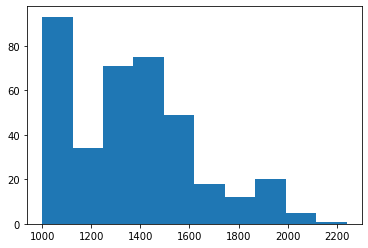

In [399]:
plt.hist(ratings)


How Many High Ranked players are there?


In [400]:
sum(valid_battles['p1_rating'] > HIGH_RATING) + sum(valid_battles['p2_rating'] > HIGH_RATING)

50

Do team statistics look different for high ranked players?

In [401]:
hr_starter_pokemon_counter = Counter()
hr_pokemon_counter = Counter()

for p in ["p1", "p2"]:
    df = valid_battles[valid_battles[p + "_rating"] >= HIGH_RATING]
    hr_starter_pokemon_counter.update(df[p + '_poke1'])

    hr_pokemon_counter.update(df[p + '_poke1'])
    hr_pokemon_counter.update(df[p + '_poke2'])
    hr_pokemon_counter.update(df[p + '_poke3'])
    hr_pokemon_counter.update(df[p + '_poke4'])
    hr_pokemon_counter.update(df[p + '_poke5'])
    hr_pokemon_counter.update(df[p + '_poke6'])

del hr_starter_pokemon_counter[UNKNOWN_POKEMON]
del hr_starter_pokemon_counter[NO_POKEMON]

del hr_pokemon_counter[UNKNOWN_POKEMON]
del hr_pokemon_counter[NO_POKEMON]



In [402]:
hr_starter_pokemon_counter.most_common(20)

[('Xatu', 4),
 ('Arctovish', 2),
 ('Runerigus', 2),
 ('Avalugg', 2),
 ('Mantine', 2),
 ('Articuno', 2),
 ('Rhyperior', 2),
 ('Pyukumuku', 2),
 ('Claydol', 2),
 ('Rhydon', 2),
 ('Sharpedo', 2),
 ('Inteleon', 2),
 ('Cofagrigus', 2),
 ('Ho-Oh', 2),
 ('Salazzle', 2),
 ('Snorlax', 2),
 ('Gigalith', 2),
 ('Kyurem', 2),
 ('Goodra', 2),
 ('Thievul', 2)]

In [403]:
hr_pokemon_counter.most_common(20)


[('Salazzle', 8),
 ('Slowbro', 6),
 ('Jellicent', 6),
 ('Porygon2', 5),
 ('Slowking', 5),
 ('Claydol', 4),
 ('Snorlax', 4),
 ('Xatu', 4),
 ('Kyurem', 4),
 ('Dugtrio', 4),
 ('Solgaleo', 4),
 ('Coalossal', 4),
 ('Diggersby', 4),
 ('Exeggutor', 4),
 ('Tapu Fini', 4),
 ('Giratina', 4),
 ('Rotom', 4),
 ('Excadrill', 4),
 ('Duraludon', 4),
 ('Electivire', 4)]

## Saving Data

In [404]:
valid_battles.to_csv(OUTPUT_DIR + '/battle_stats.csv')
